In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_defaults import *
from scipy.optimize import curve_fit

In [2]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS # ordinary least squares
from statsmodels.stats.outliers_influence import summary_table

In [3]:
file_path = 'Data_S1_v3.xlsx'

df = pd.read_excel(file_path, sheet_name='Fig. S1,S2', header=0) 

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
df.head()

,Body length snout -cloaca (cm),Body length snout - tail (cm),Body Weight (g),Limb width (mm),Limb width (mm) /body length s-c (cm),Limb width (mm) / body length s-t (cm),Blastema width (mm),Blastema width / Limb width,Unnamed: 8,Unnamed: 9,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35
0,2.1,3.8,0.44,1.043,0.496667,0.274474,1.021,0.978907,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blastema size vs limb size
1,2.0,3.8,0.43,1.261,0.630500,0.331842,1.017,0.806503,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.3,8.3,4.56,2.408,0.560000,0.290120,1.847,0.767027,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.1,3.9,0.44,1.311,0.624286,0.336154,0.969,0.739130,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.3,8.3,4.13,2.342,0.544651,0.282169,1.669,0.712639,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['Animal length (snout to tail), mm'] = 10 * df['Body length snout - tail (cm)']

In [6]:
def compute_centered_r2(observed, predicted):
    """
    Compute the centered R² value for observed and predicted data. As in Excel. 
    Functions for statistical models return NOT centered value.
    """
    # Convert inputs to numpy arrays
    observed = np.array(observed)
    predicted = np.array(predicted)

    # Mean of observed values
    mean_observed = np.mean(observed)

    # Centered Total Sum of Squares (TSS)
    tss_centered = np.sum((observed - mean_observed) ** 2)

    # Sum of Squared Residuals (SSR)
    ssr = np.sum((observed - predicted) ** 2)

    # Centered R²
    r_sq_centered = 1 - ssr / tss_centered

    return r_sq_centered

# Plot limb width vs. animal size

In [7]:
# animals size and limb width
df_plot = df.dropna(subset=['Animal length (snout to tail), mm', 'Limb width (mm)'])
df_plot = df_plot.sort_values(by='Animal length (snout to tail), mm')
animal_size_limb, limb_width = np.array( df_plot['Animal length (snout to tail), mm'] ), np.array( df_plot['Limb width (mm)'] )

In [8]:
# Fit regression without intercept
model_regr_no_interc = OLS(limb_width, animal_size_limb).fit() # ordinary least squares, takes, Y, X
# Regression results
slope = model_regr_no_interc.params[0]
slope_error = model_regr_no_interc.bse[0]  # Standard error of the slope

r_sq_regr_no_interc = compute_centered_r2(limb_width, model_regr_no_interc.fittedvalues)

# Confidence intervals
_, data, _ = summary_table(model_regr_no_interc, alpha=0.05)
#predict_mean_se_regr_no_interc = data[:, 3]
mean_ci_low_regr_no_interc, mean_ci_high_regr_no_interc = data[:, 4:6].T  # Extract confidence interval bounds

In [9]:
# Log-transform the data
log_x = np.log(animal_size_limb)
log_y = np.log(limb_width)

# Fit linear regression on the transformed data (log-log regression)
model_power = sm.OLS(log_y, sm.add_constant(log_x)).fit()

# Extract the power (n) and intercept from the model
intercept_power = model_power.params[0]
power = model_power.params[1]
power_error = model_power.bse[1]
r_sq_power = compute_centered_r2( log_y, model_power.fittedvalues )

# Confidence intervals
_, data, _ = summary_table(model_power, alpha=0.05)
mean_ci_low_power, mean_ci_high_power = data[:, 4:6].T

# Transform the fitted values and confidence intervals back to the original scale
mean_ci_low_power = np.exp(mean_ci_low_power)
mean_ci_high_power = np.exp(mean_ci_high_power)

In [10]:
# Compute the mean of y
y = limb_width/animal_size_limb
mean = np.mean(y)

# Compute statistical errors
std = np.std(y, ddof=1)  # Standard deviation
n = len(y)  # Number of samples
stderr = std / np.sqrt(n)  # Standard error of the mean

# 95% confidence intervals (mean ± 1.96 * stderr)
ci_low_const  = mean - 1.96 * stderr
ci_high_const = mean + 1.96 * stderr

In [11]:
widthBl    = np.array( df['Blastema width (mm)'] )
sizeAnimal = np.array( df['Animal length (snout to tail), mm'] )

sizeAnimal = sizeAnimal[ ~np.isnan(widthBl) ]
widthBl    = widthBl[ ~np.isnan(widthBl) ]

blastema_width, animal_size_bl = widthBl[ np.argsort(sizeAnimal) ], sizeAnimal[ np.argsort(sizeAnimal) ]

In [12]:
# Log-transform the data
log_x = np.log(animal_size_bl)
log_y = np.log(blastema_width)

# Fit linear regression on the transformed data (log-log regression)
model_power = sm.OLS(log_y, sm.add_constant(log_x)).fit()

# Extract the power (n) and intercept from the model
intercept_power_bl = model_power.params[0]
power_bl = model_power.params[1]
power_error_bl = model_power.bse[1]
r_sq_power_bl = compute_centered_r2( log_y, model_power.fittedvalues )

# Confidence intervals
_, data, _ = summary_table(model_power, alpha=0.05)
mean_ci_low_power_bl, mean_ci_high_power_bl = data[:, 4:6].T

# Transform the fitted values and confidence intervals back to the original scale
mean_ci_low_power_bl = np.exp(mean_ci_low_power_bl)
mean_ci_high_power_bl = np.exp(mean_ci_high_power_bl)

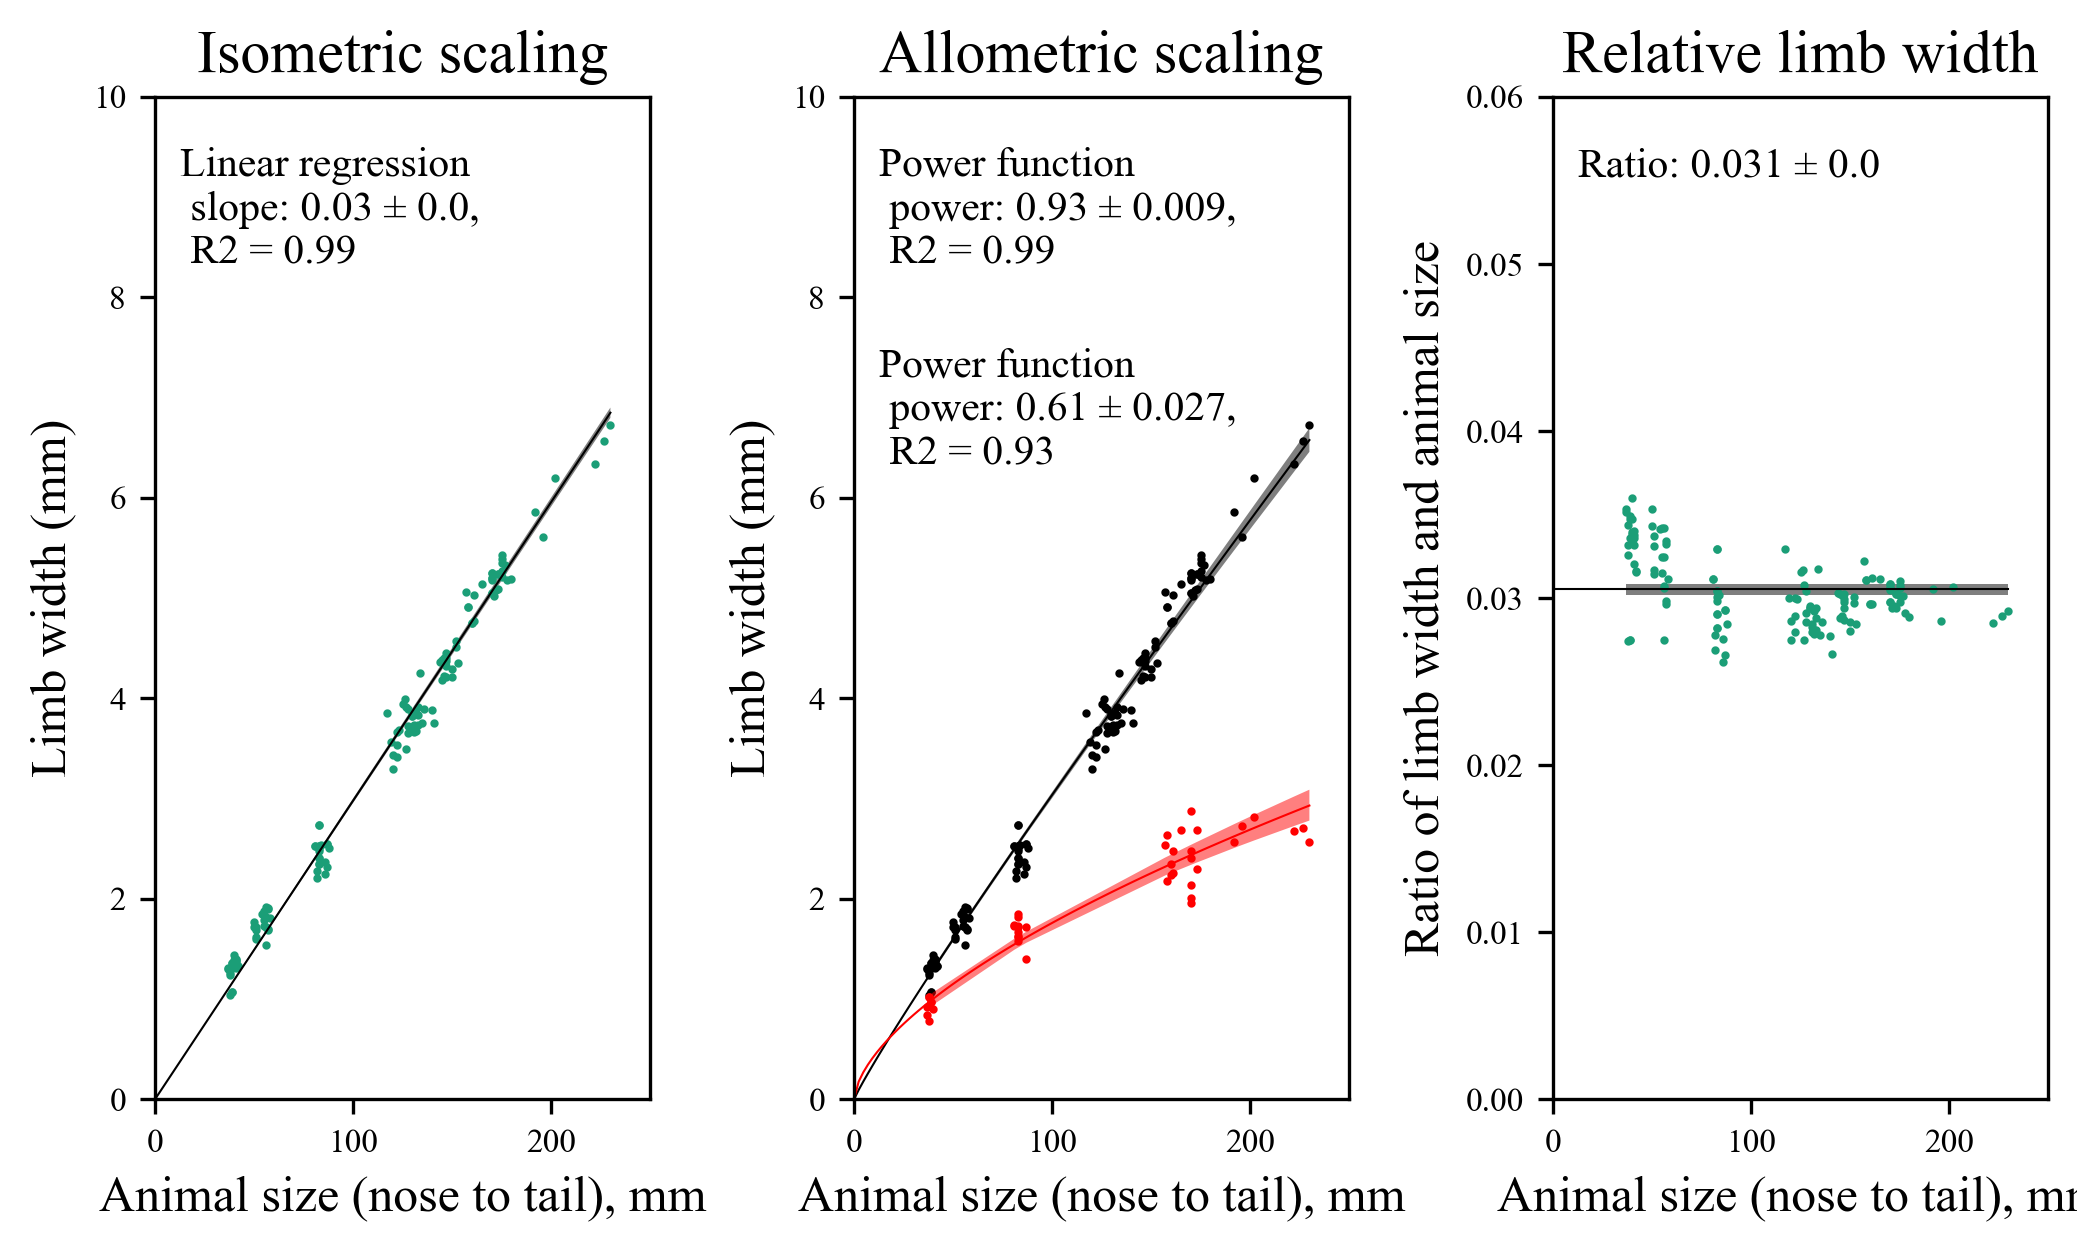

In [13]:
nrows, ncols = 1, 3

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/2), sharex=False, sharey=False)

x = np.linspace(0, max(animal_size_limb), 100)

################# plot 1 #################
ax = plt.subplot(nrows, ncols, 1)

# Plot regression line
ax.plot( 
    x, 
    slope * x, 
    color='black'
)
# Add text in the upper left corner
ax.text(
    0.05, 0.95, 
    f'Linear regression\n slope: {round(slope, 3)} ± {round(slope_error, 3)},\n R2 = {round(r_sq_regr_no_interc, 2)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')

# Plot confidence intervals
ax.fill_between(
    animal_size_limb, 
    mean_ci_low_regr_no_interc,
    mean_ci_high_regr_no_interc,
    facecolor='black', edgecolor='none', alpha=0.5
)
ax.scatter( animal_size_limb, limb_width, s=1 )
ax.set_xlim( 0, 250 )
ax.set_ylim( 0, 10 )
ax.set_xlabel( 'Animal size (nose to tail), mm' )
ax.set_ylabel( 'Limb width (mm)' )
ax.set_title('Isometric scaling')

################# plot 2 #################
ax = plt.subplot(nrows, ncols, 2)

# Plot power fit
ax.plot(
    x, 
    np.exp(intercept_power) * x**power, 
    color='black'
)
ax.text(
    0.05, 0.95, 
    f'Power function\n power: {round(power, 2)} ± {round(power_error, 3)},\n R2 = {round(r_sq_power, 2)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')

# Plot confidence intervals
ax.fill_between(
    animal_size_limb, 
    mean_ci_low_power,
    mean_ci_high_power,
    facecolor='black', edgecolor='none', alpha=0.5
)
ax.scatter( animal_size_limb, limb_width, s=1, color='black' )

ax.plot(
    x, 
    np.exp(intercept_power_bl) * x**power_bl, 
    color='red'
)
ax.text(
    0.05, 0.75, 
    f'Power function\n power: {round(power_bl, 2)} ± {round(power_error_bl, 3)},\n R2 = {round(r_sq_power_bl, 2)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')
ax.fill_between(
    animal_size_bl, 
    mean_ci_low_power_bl,
    mean_ci_high_power_bl,
    facecolor='red', edgecolor='none', alpha=0.5
)
ax.scatter( animal_size_bl,  blastema_width, s=1, color='red' )

ax.set_xlim( 0, 250 )
ax.set_ylim( 0, 10 )
ax.set_ylabel( 'Limb width (mm)' )
ax.set_xlabel( 'Animal size (nose to tail), mm' )
ax.set_title('Allometric scaling')

################# plot 3 #################
ax = plt.subplot(nrows, ncols, 3)

# Plot power fit
ax.plot(
    x, 
    np.zeros_like(x) + mean,
    color='black'
)

ax.text(
    0.05, 0.95, 
    f'Ratio: {round(mean, 3)} ± {round(stderr, 3)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')


# Plot confidence intervals
ax.fill_between(
    animal_size_limb, 
    ci_low_const,
    ci_high_const,
    facecolor='black', edgecolor='none', alpha=0.5
)

ax.scatter( animal_size_limb, limb_width/animal_size_limb, s=1 )

ax.set_xlim( 0, 250 )
ax.set_ylim( 0, 0.06 )
ax.set_ylabel( 'Ratio of limb width and animal size' )
ax.set_xlabel( 'Animal size (nose to tail), mm' )
ax.set_title('Relative limb width')

plt.tight_layout()
plt.savefig('limb_width_vs_animal_size.pdf')
plt.show()

# Plot blstema width vs. limb size

In [14]:
widthBl    = np.array( df['Blastema width (mm)'] )
limb_width = np.array( df['Limb width (mm)'] )

limb_width = limb_width[ ~np.isnan(widthBl) ]
widthBl    = widthBl[ ~np.isnan(widthBl) ]

blastema_width, limb_width = widthBl[ np.argsort(limb_width) ], limb_width[ np.argsort(limb_width) ]

In [15]:
# Fit regression without intercept
model_regr = OLS(blastema_width, limb_width).fit() # ordinary least squares, takes, Y, X
# Regression results
slope_regr = model_regr.params[0]
slope_error_regr = model_regr.bse[0]  # Standard error of the slope

r_sq_regr = compute_centered_r2(blastema_width, model_regr.fittedvalues)

# Confidence intervals
_, data, _ = summary_table(model_regr, alpha=0.05)
#predict_mean_se_regr_no_interc = data[:, 3]
mean_ci_low_regr, mean_ci_high_regr = data[:, 4:6].T  # Extract confidence interval bounds

In [16]:
# Log-transform the data
log_x = np.log(limb_width)
log_y = np.log(blastema_width)

# Fit linear regression on the transformed data (log-log regression)
model_power = sm.OLS(log_y, sm.add_constant(log_x)).fit()

# Extract the power (n) and intercept from the model
intercept_power = model_power.params[0]
power = model_power.params[1]
power_error = model_power.bse[1]
r_sq_power = compute_centered_r2(log_y, model_power.fittedvalues)

# Confidence intervals
_, data, _ = summary_table(model_power, alpha=0.05)
mean_ci_low_power, mean_ci_high_power = data[:, 4:6].T

# Transform the fitted values and confidence intervals back to the original scale
mean_ci_low_power = np.exp(mean_ci_low_power)
mean_ci_high_power = np.exp(mean_ci_high_power)

In [17]:
# for ratio
# Fit regression with intercept
model_regr_ratio = OLS(blastema_width/limb_width, sm.add_constant(limb_width)).fit() # ordinary least squares, takes, Y, X
# Regression results
intercept_regr_ratio = model_regr_ratio.params[0]
intercept_error_regr_ratio = model_regr_ratio.bse[0]  # Standard error of the slope

slope_regr_ratio = model_regr_ratio.params[1]
slope_error_regr_ratio = model_regr_ratio.bse[1]  # Standard error of the slope

r_sq_regr_ratio = compute_centered_r2(blastema_width/limb_width, model_regr_ratio.fittedvalues)

# Confidence intervals
_, data, _ = summary_table(model_regr_ratio, alpha=0.05)
#predict_mean_se_regr_no_interc = data[:, 3]
mean_ci_low_regr_ratio, mean_ci_high_regr_ratio = data[:, 4:6].T  # Extract confidence interval bounds

In [18]:
file_path = 'Data_S1_v3.xlsx'

df_hcr = pd.read_excel(file_path, header=0) 

In [19]:
slope

0.02977486008560666

In [20]:
df_hcr['Animal length group, cm'].unique()

array([1.5       , 2.92857143, 5.3       , 7.2625    ])

In [21]:
colormap = plt.colormaps['Dark2']
colors = colormap(np.linspace(0, 1, 10))
sizes = df_hcr['Animal length group, cm'].unique()
size_to_color = {
    sizes[0]: colors[1], 
    sizes[1]: colors[2],
    sizes[2]: colors[3],
    sizes[3]: colors[4]
}
df_hcr['color'] = df_hcr['Animal length group, cm'].map(size_to_color)

In [22]:
df_hcr = df_hcr[df_hcr['Animal length group, cm'] != 1.5]

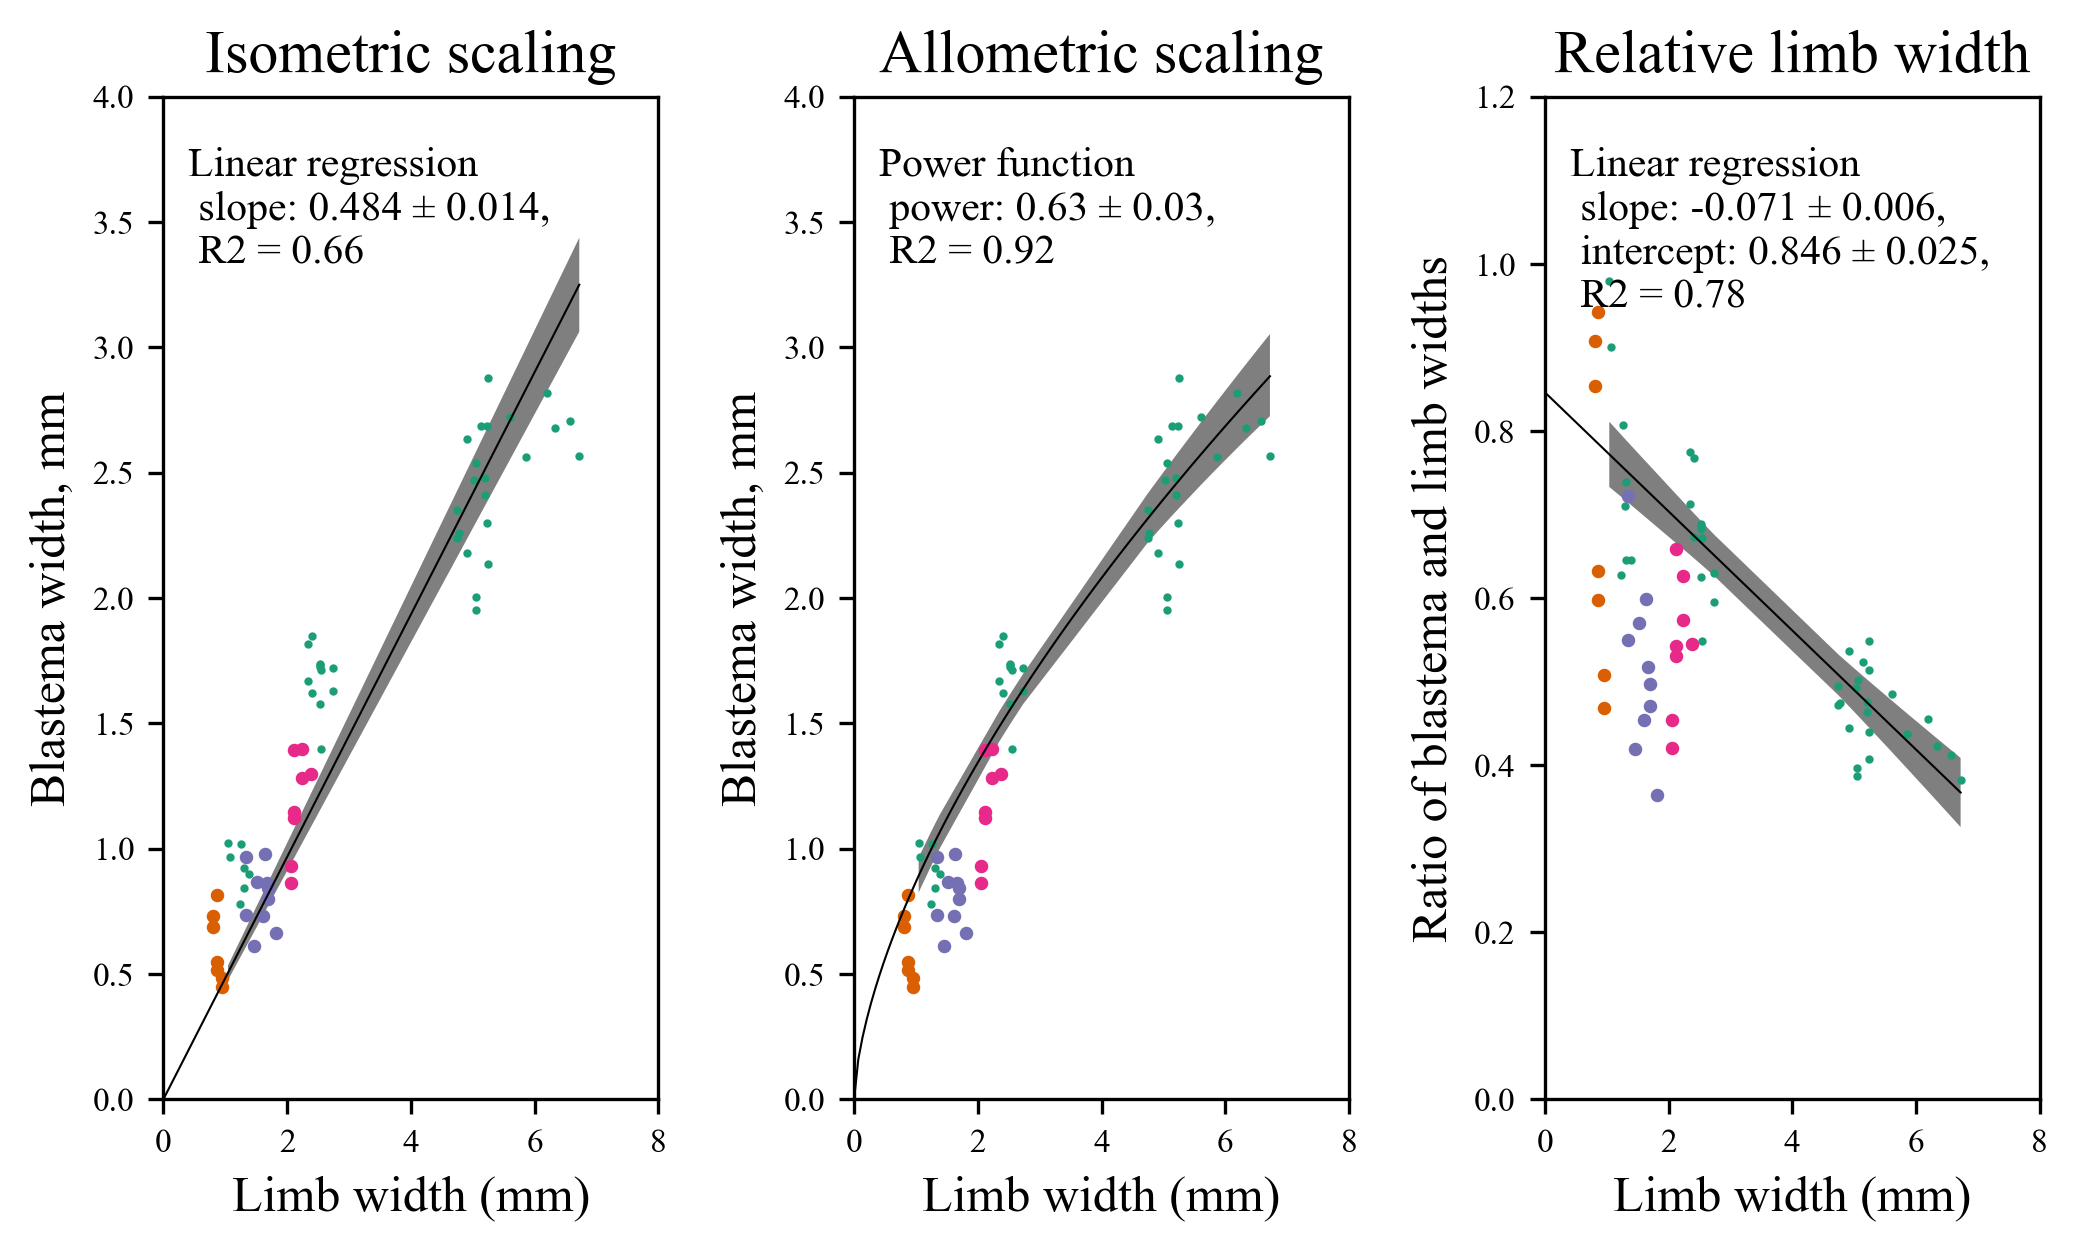

In [27]:
nrows, ncols = 1, 3

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/2), sharex=False, sharey=False)

x = np.linspace(0, max(limb_width), 100)

################# plot 1 #################
ax = plt.subplot(nrows, ncols, 1)

# Plot regression line
ax.plot( 
    x, 
    slope_regr * x,# + intercept_regr, 
    color='black'
)
# Add text in the upper left corner
ax.text(
    0.05, 0.95, 
    f'Linear regression\n slope: {round(slope_regr, 3)} ± {round(slope_error_regr, 3)},\n R2 = {round(r_sq_regr, 2)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')

# Plot confidence intervals
ax.fill_between(
    limb_width, 
    mean_ci_low_regr,
    mean_ci_high_regr,
    facecolor='black', edgecolor='none', alpha=0.5
)
ax.scatter( limb_width, blastema_width, s=1 )
for size in sizes:
    df_regr = df_hcr[df_hcr['Animal length group, cm'] == size]
    # from hcr 
    ax.scatter(
        10 * slope * df_regr['Exact animal length (snout to tail), cm'],
        1e-3 * df_regr['Blastema width, um'],
        s=5,
        edgecolor=size_to_color[size], facecolor=size_to_color[size]
    )
    
ax.set_xlim( 0, 8 )
ax.set_ylim( 0, 4 )
ax.set_xlabel( 'Limb width (mm)' )
ax.set_ylabel( 'Blastema width, mm' )
ax.set_title('Isometric scaling')

################# plot 2 #################
ax = plt.subplot(nrows, ncols, 2)

# Plot power fit
ax.plot(
    x, 
    np.exp(intercept_power) * x**power, 
    color='black'
)
ax.text(
    0.05, 0.95, 
    f'Power function\n power: {round(power, 2)} ± {round(power_error, 3)},\n R2 = {round(r_sq_power, 2)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')

# Plot confidence intervals
ax.fill_between(
    limb_width, 
    mean_ci_low_power,
    mean_ci_high_power,
    facecolor='black', edgecolor='none', alpha=0.5
)
ax.scatter( limb_width, blastema_width, s=1 )
for size in sizes:
    df_regr = df_hcr[df_hcr['Animal length group, cm'] == size]
    # from hcr 
    ax.scatter(
        10 * slope * df_regr['Exact animal length (snout to tail), cm'],
        1e-3 * df_regr['Blastema width, um'],
        s=5,
        edgecolor=size_to_color[size], facecolor=size_to_color[size]
    )

ax.set_xlim( 0, 8 )
ax.set_ylim( 0, 4 )
ax.set_xlabel( 'Limb width (mm)' )
ax.set_ylabel( 'Blastema width, mm' )
ax.set_title('Allometric scaling')

################# plot 3 #################
ax = plt.subplot(nrows, ncols, 3)

# Plot regression line
ax.plot( 
    x, 
    slope_regr_ratio * x + intercept_regr_ratio, 
    color='black'
)
# Add text in the upper left corner
ax.text(
    0.05, 0.95, 
    f'Linear regression\n slope: {round(slope_regr_ratio, 3)} ± {round(slope_error_regr_ratio, 3)},\n intercept: {round(intercept_regr_ratio, 3)} ± {round(intercept_error_regr_ratio, 3)},\n R2 = {round(r_sq_regr_ratio, 2)}', 
    fontsize=10, color="black", transform=plt.gca().transAxes, verticalalignment='top')

# Plot confidence intervals
ax.fill_between(
    limb_width, 
    mean_ci_low_regr_ratio,
    mean_ci_high_regr_ratio,
    facecolor='black', edgecolor='none', alpha=0.5
)

ax.scatter( limb_width, blastema_width/limb_width, s=1 )
for size in sizes:
    df_regr = df_hcr[df_hcr['Animal length group, cm'] == size]
    # from hcr 
    ax.scatter(
        10 * slope * df_regr['Exact animal length (snout to tail), cm'],
        1e-3 * df_regr['Blastema width, um']/ (10 * slope * df_regr['Exact animal length (snout to tail), cm'] ),
        s=5,
        edgecolor=size_to_color[size], facecolor=size_to_color[size]
    )
    
ax.set_xlim( 0, 8 )
ax.set_ylim( 0, 1.2 )
ax.set_ylabel( 'Ratio of blastema and limb widths' )
ax.set_xlabel( 'Limb width (mm)' )
ax.set_title('Relative limb width')

plt.tight_layout()
plt.savefig('blastema_width_vs_limb_width.pdf')
plt.show()